In [55]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt


In [ ]:
IMG_SIZE = 224
NUM_CLASSES = 2
DATA_DIR = "DATA"  

train_csv_path = os.path.join(DATA_DIR, "train.csv")
test_csv_path = os.path.join(DATA_DIR, "test.csv")

train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

print("Train DataFrame:")
print(train_df.head())
print("\nTest DataFrame:")
print(test_df.head())


Train DataFrame:
   Image  Label
0  1.jpg      0
1  2.jpg      0
2  3.jpg      1
3  4.jpg      1
4  5.jpg      0

Test DataFrame:
     Image  Label
0  946.jpg      1
1  947.jpg      1
2  948.jpg      0
3  949.jpg      1
4  950.jpg      1


In [59]:
print(train_df.columns)
print(test_df.columns)


Index(['Image', 'Label'], dtype='object')
Index(['Image', 'Label'], dtype='object')


In [ ]:
def load_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    return img_array

train_images = []
train_labels = []
test_images = []
test_labels = []

for idx, row in train_df.iterrows():
    img_path = os.path.join(DATA_DIR, "train", row['Image'])  
    label = row['Label'] 
    img_array = load_image(img_path)
    train_images.append(img_array)
    train_labels.append(label)

for idx, row in test_df.iterrows():
    img_path = os.path.join(DATA_DIR, "test", row['Image'])  
    label = row['Label'] 
    img_array = load_image(img_path)
    test_images.append(img_array)
    test_labels.append(label)

train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

train_images = train_images / 255.0
test_images = test_images / 255.0

print(f"Dimensions des images d'entraînement: {train_images.shape}")
print(f"Dimensions des images de test: {test_images.shape}")


Dimensions des images d'entraînement: (945, 224, 224, 3)
Dimensions des images de test: (402, 224, 224, 3)


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

for layer in base_model.layers[-40:]:  
    layer.trainable = True

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),  
    layers.Dense(4096, activation='relu', kernel_regularizer=l2(0.01)),  
    layers.Dropout(0.5), 
    layers.BatchNormalization(),  
    layers.Dense(2048, activation='relu', kernel_regularizer=l2(0.01)),  
    layers.Dropout(0.5),  
    layers.Dense(1024, activation='relu', kernel_regularizer=l2(0.01)), 
    layers.Dropout(0.5),  
    layers.Dense(NUM_CLASSES, activation='softmax') 
])

model.compile(optimizer=Adam(learning_rate=0.00005),  
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

model.summary()

history = model.fit(train_images, train_labels,
                    epochs=10,  
                    batch_size=32,
                    validation_data=(test_images, test_labels),
                    callbacks=[lr_scheduler])


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 4096)           │     5,246,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 4096)           │        16,384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 2048)           │     8,390,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,808,933 (75.57 MB)

 Trainable params: 19,756,158 (75.36 MB)

 Non-trainable params: 52,775 (206.16 KB)

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 167s 3s/step - accuracy: 0.5558 - loss: 61.3999 - val_accuracy: 0.5075 - val_loss: 60.3545 - learning_rate: 5.0000e-05
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.7282 - loss: 60.0911 - val_accuracy: 0.5075 - val_loss: 59.5069 - learning_rate: 5.0000e-05
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.7534 - loss: 59.1401 - val_accuracy: 0.5075 - val_loss: 58.7445 - learning_rate: 5.0000e-05
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.8405 - loss: 58.1223 - val_accuracy: 0.5075 - val_loss: 57.9521 - learning_rate: 5.0000e-05
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.8760 - loss: 57.0949 - val_accuracy: 0.5075 - val_loss: 57.1626 - learning_rate: 5.0000e-05
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.9079 - loss: 56.0509 - val_accuracy: 0.5075 - val_loss: 56.2300 - learning_rate: 5.0000e-05
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0

In [ ]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 417ms/step - accuracy: 0.5044 - loss: 53.5883
Test Loss: 53.5889
Test Accuracy: 0.5075


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


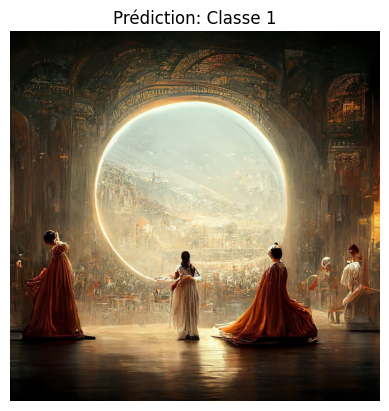

Probabilité de la classe prédite: 0.9945


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def load_and_preprocess_image(img_path, target_size=(IMG_SIZE, IMG_SIZE)):
    img = image.load_img(img_path, target_size=target_size)  
    img_array = image.img_to_array(img)  
    img_array = np.expand_dims(img_array, axis=0) 
    img_array = img_array / 255.0  
    return img_array

img_path = 'ai.jpg'  
img_array = load_and_preprocess_image(img_path)

predictions = model.predict(img_array)

predicted_class = np.argmax(predictions, axis=1)

plt.imshow(image.load_img(img_path))
plt.title(f"Prédiction: Classe {predicted_class[0]}") 
plt.axis('off') 
plt.show()

print(f"Probabilité de la classe prédite: {predictions[0][predicted_class[0]]:.4f}")


In [ ]:
model.save('model_effnet_2.h5')


print("Le modèle a été enregistré avec succès.")


Le modèle a été enregistré avec succès.
